In [ ]:
import pandas as pd
from rnn import simpleRnn
import torch.optim as optim
import torch.nn as nn


ModuleNotFoundError: No module named 'lstm'

In [ ]:
df  = pd.read_csv("100_Unique_QA_Dataset.csv")
df.head()

,question,answer
0,What is the capital of France?,Paris
1,What is the capital of Germany?,Berlin
2,Who wrote 'To Kill a Mockingbird'?,Harper-Lee
3,What is the largest planet in our solar system?,Jupiter
4,What is the boiling point of water in Celsius?,100


In [ ]:
df.shape

(90, 2)

In [ ]:
def preprocess(text):
    text = text.lower()
    text = text.replace("?","")
    text = text.replace("'","")
    return text.split()

In [ ]:
df['clean_Q'] = df['question'].apply(preprocess)
df['clean_A'] = df['answer'].apply(preprocess)

In [ ]:
df.head()

,question,answer,clean_Q,clean_A
0,What is the capital of France?,Paris,"[what, is, the, capital, of, france]",[paris]
1,What is the capital of Germany?,Berlin,"[what, is, the, capital, of, germany]",[berlin]
2,Who wrote 'To Kill a Mockingbird'?,Harper-Lee,"[who, wrote, to, kill, a, mockingbird]",[harper-lee]
3,What is the largest planet in our solar system?,Jupiter,"[what, is, the, largest, planet, in, our, sola...",[jupiter]
4,What is the boiling point of water in Celsius?,100,"[what, is, the, boiling, point, of, water, in,...",[100]


In [ ]:
vocab = {'UNK':0}

In [ ]:
# Convert clean_Q and clean_A to list of tokens
questions_tokens = df['clean_Q'].tolist()
answers_tokens = df['clean_A'].tolist()

# Update vocab with unique tokens from clean_Q and clean_A
for tokens in questions_tokens + answers_tokens:
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab)

print("Vocabulary:", vocab)

Vocabulary: {'UNK': 0, 'what': 1, 'is': 2, 'the': 3, 'capital': 4, 'of': 5, 'france': 6, 'germany': 7, 'who': 8, 'wrote': 9, 'to': 10, 'kill': 11, 'a': 12, 'mockingbird': 13, 'largest': 14, 'planet': 15, 'in': 16, 'our': 17, 'solar': 18, 'system': 19, 'boiling': 20, 'point': 21, 'water': 22, 'celsius': 23, 'painted': 24, 'mona': 25, 'lisa': 26, 'square': 27, 'root': 28, '64': 29, 'chemical': 30, 'symbol': 31, 'for': 32, 'gold': 33, 'which': 34, 'year': 35, 'did': 36, 'world': 37, 'war': 38, 'ii': 39, 'end': 40, 'longest': 41, 'river': 42, 'japan': 43, 'developed': 44, 'theory': 45, 'relativity': 46, 'freezing': 47, 'fahrenheit': 48, 'known': 49, 'as': 50, 'red': 51, 'author': 52, '1984': 53, 'currency': 54, 'united': 55, 'kingdom': 56, 'india': 57, 'discovered': 58, 'gravity': 59, 'how': 60, 'many': 61, 'continents': 62, 'are': 63, 'there': 64, 'on': 65, 'earth': 66, 'gas': 67, 'do': 68, 'plants': 69, 'use': 70, 'photosynthesis': 71, 'smallest': 72, 'prime': 73, 'number': 74, 'invented

In [ ]:
def convert_to_tokens(words):
    return [vocab.get(word, vocab['UNK']) for word in words]

df['tokenized_Q'] = df['clean_Q'].apply(convert_to_tokens)
df['tokenized_A'] = df['clean_A'].apply(convert_to_tokens)

In [ ]:
from torch.utils.data import DataLoader,Dataset
import torch

In [ ]:
class QADataset(Dataset):

    def __init__(self,df,vocab):
        self.df = df
        self.vocab = vocab
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        questions = torch.tensor(self.df['tokenized_Q'].iloc[index])
        answers = torch.tensor(self.df['tokenized_A'].iloc[index])
        return questions, answers

In [ ]:
dataset = QADataset(df,vocab)


In [ ]:
dataloader = DataLoader(dataset=dataset, batch_size=1,shuffle=True)

In [ ]:
model = simpleRnn(len(vocab),100,64)


In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
model

simpleRnn(
  (embedding_layer): Embedding(324, 100)
  (encoding_layer): RNN(100, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=324, bias=True)
)

In [ ]:
epochs = 20
track_loss = []


In [59]:
for epoch in range(epochs):
    total_loss=0
    for q,a in dataloader:
        optimizer.zero_grad()
        prediction = model(q)
        pred_loss = loss(prediction,a[0])
        pred_loss.backward()
        optimizer.step()
        total_loss+=(pred_loss.item())
    print(f"Epoch:{epoch+1}\t Loss:{total_loss:.4f}")
    track_loss.append(total_loss)

Epoch:1	 Loss:526.8921
Epoch:2	 Loss:444.1317
Epoch:3	 Loss:362.1520
Epoch:4	 Loss:287.5827
Epoch:5	 Loss:226.1638
Epoch:6	 Loss:174.7701
Epoch:7	 Loss:131.2595
Epoch:8	 Loss:98.3683
Epoch:9	 Loss:73.4149
Epoch:10	 Loss:56.5397
Epoch:11	 Loss:43.7458
Epoch:12	 Loss:35.1321
Epoch:13	 Loss:28.4309
Epoch:14	 Loss:23.9260
Epoch:15	 Loss:20.0147
Epoch:16	 Loss:17.3433
Epoch:17	 Loss:14.8238
Epoch:18	 Loss:12.7033
Epoch:19	 Loss:11.1752
Epoch:20	 Loss:9.8483


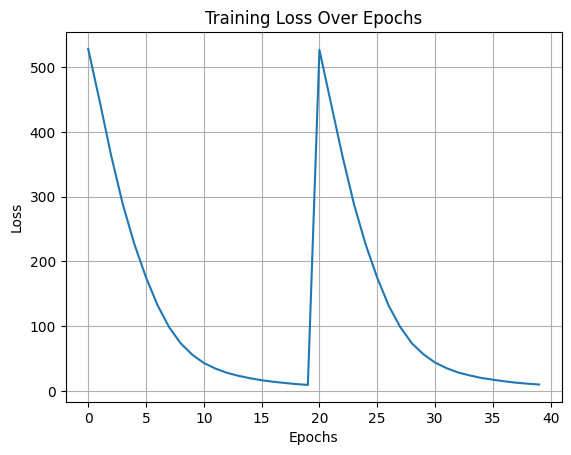

In [60]:
import matplotlib.pyplot as plt

plt.plot(track_loss)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [61]:
def predict(model, question, threshold=0.5):

    # convert question to numbers
    numerical_question = convert_to_tokens(question)

    # tensor
    question_tensor = torch.tensor(numerical_question).unsqueeze(0)

    # send to model
    output = model(question_tensor)

    # convert logits to probs
    probs = torch.nn.functional.softmax(output, dim=1)

    # find index of max prob
    value, index = torch.max(probs, dim=1)
    print(value, index)
    if value < threshold:
        print("I don't know")

    print(list(vocab.keys())[index])

In [62]:
predict(model,"capital of paris")

tensor([0.0217], grad_fn=<MaxBackward0>) tensor([300])
I don't know
february


In [36]:
dataset[0][0]

tensor([1, 2, 3, 4, 5, 6])